In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mysql.connector
import pymysql
from draw_pitch import draw_pitch
import seaborn as sns
from add_features import calc_angle, calc_distance_to_goal, assist_distance
import seaborn as sns

In [3]:
# get data, decapitalize columns
sql = 'SELECT * FROM stratagem.chances WHERE icon NOT IN (\'penawarded\', \'penmissed\')'
        # WHERE type = \'open play\' AND bodypart IN (\'right\', \'left\')'

cnx = pymysql.connect(user='root', password='anton', host='localhost', database='stratagem')

df = pd.read_sql(sql,cnx)
cnx.close()

for col in df.columns:
    df.rename(columns={col: col.lower()}, inplace=True)

In [4]:
col_to_num = ['location_x', 'location_y', 
              'primarylocation_x', 'primarylocation_y',
              'numdefplayers', 'numattplayers', 
              'defpressure', 'shotquality']

# make numeric columns numeric, non-numeric will be NaN
for col in col_to_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# rename some columns and transpose
df.rename(columns={'location_x': 'y', 'location_y': 'x',
                   'primarylocation_x':'y2', 'primarylocation_y': 'x2',
                   'hometeam_team1': 'hometeam','awayteam_team2': 'awayteam'}, inplace=True)

In [5]:
def make_seconds(in_time):
    minute, second = in_time.split(':')
    if minute[0] == '0':
        minute == minute[1]
    return int(minute) * 60 + int(second)

df['time'] = df.apply(lambda x: make_seconds(x['time']), axis=1)

In [6]:
# convert coords to between 0 - 100
df.y = (df.y + 136)/ (1.36 * 2)
df.x = (df.x) / 4.2

df.y2 = (df.y2 + 136)/ (1.36 * 2)
df.x2 = (df.x2) / 4.2

# convert coords to meters
pitch_width = 68.0
pitch_length = 105.0
goal_size = 7.32

df['x'] = df['x'].apply(lambda x: x*pitch_length/100)
df['y'] = df['y'].apply(lambda x: x*pitch_width/100)

df['x2'] = df['x2'].apply(lambda x: x*pitch_length/100)
df['y2'] = df['y2'].apply(lambda x: x*pitch_width/100)

In [7]:
# functions imported from add_features.py
df['angle'] = df.apply(lambda x: calc_angle(x['x'], x['y']), axis=1)
df['distance'] = df.apply(lambda x: calc_distance_to_goal(x['x'], x['y']), axis=1)

# method above returns log distance + 1
df['distance'] = np.exp(df['distance']) - 1

In [8]:
def set_gamestate(gsm_id, temp_list=[]):
    
    # crete temporary df from index, sort by time
    df_temp = df[df['gsm_id'] == gsm_id][['hometeam', 'awayteam', 'team', 'time', 'icon']]    
    df_temp = df_temp.sort_values(by='time')
    # set gamestate to 0 and then to 1 for home goal, -1 for away goal
    df_temp['gamestate'] = 0
    df_temp.loc[(df_temp['icon'] == "goal") & (df_temp['team'] == df_temp["hometeam"]), 'gamestate'] = 1
    df_temp.loc[(df_temp['icon'] == "goal") & (df_temp['team'] == df_temp["awayteam"]), 'gamestate'] = -1
    # shift down so the gamestate changes for events after goal, shift creates na that is replaced w/ 0
    df_temp.gamestate = df_temp.gamestate.shift(1)
    df_temp.gamestate = df_temp.gamestate.fillna(0)
    # calculate cumulative sum in gamestate, then switch sign on away-team
    df_temp.gamestate = df_temp.gamestate.cumsum()
    df_temp.loc[df_temp['team'] == df_temp["awayteam"], 'gamestate'] = df_temp.gamestate * - 1
    # add temp_df to temp list
    temp_list.append(df_temp[['gamestate']])
    return temp_list
    
for gsm_id in df.gsm_id.unique():    
    temp_list = set_gamestate(gsm_id)
    
# concat all temp dfs and add to original df
df_temp = pd.concat(temp_list, axis=0)
df = pd.concat((df, df_temp), axis=1)

In [9]:
# number of homegoals
homegoal = df[(df['icon'] == 'goal') & (df['team'] == df['hometeam'])].groupby('competition').count()['index']
# number of awaygoals
awaygoal = df[(df['icon'] == 'goal') & (df['team'] != df['hometeam'])].groupby('competition').count()['index']
#join together to gamecount
df_goal = pd.concat((homegoal, awaygoal, df.groupby('competition')['gsm_id'].nunique()), axis=1)
# rename columns
df_goal.columns = ['homegoals', 'awaygoals', 'gamecount']
# score rates
df_goal['hrate'] = df_goal['homegoals'] / df_goal['gamecount']
df_goal['arate'] = df_goal['awaygoals'] / df_goal['gamecount']

In [10]:
from scipy.stats import poisson
import itertools

# gravity measures event importance
# it's defined by the difference in expeceted points if an event is successful or not successful 
# E(p|success) - E(p|fail) = gravity
# the method below returns E(p|score) and E(p|miss) for shots
# expected points is calculated using scoring rates for away and home across leagues and a poisson model
def gravity(competition, time, gamestate, team, hometeam):
    
    time_factor = (90 * 60 - time) / (90 * 60.0)
    
    # if more than 90 minutes
    if time_factor <= 0:
        time_factor = 0.0001
    
    # average goals to be scored in time left
    rate_home = df_goal.get_value(competition, 'hrate') * time_factor
    rate_away = df_goal.get_value(competition, 'arate') * time_factor
    
    # prob number of goals 
    p_home = [poisson.pmf(i, rate_home) for i in range(20)]
    p_away = [poisson.pmf(i, rate_away) for i in range(20)]
    
    home_win_miss = 0
    draw_miss = 0
    away_win_miss = 0
    
    home_win_goal = 0
    draw_goal = 0
    away_win_goal = 0
    
    # calculate xp for home and away win
    for home, away in itertools.product(enumerate(p_home), enumerate(p_away)):
        hg, ag = home[0], away[0]
        
        # add gamestate to goal
        if hometeam == team:
            hg += gamestate
        else:
            ag += gamestate
        
        prob = home[1] * away[1]
        
        # xp if miss
        if hg > ag:
            home_win_miss += prob
        elif hg < ag:
            away_win_miss += prob
        else:
            draw_miss += prob
        
        # xp if goal    
        if hometeam == team:
            hg += 1
        else:
            ag += 1
    
        if hg > ag:
            home_win_goal += prob
        elif hg < ag:
            away_win_goal += prob
        else:
            draw_goal += prob
    
    # xp for goal and miss
    if hometeam == team:
        xp_miss = 3 * home_win_miss + 1 * draw_miss
        xp_goal = 3 * home_win_goal + 1 * draw_goal
    else:
        xp_miss = 3 * away_win_miss + 1 * draw_miss
        xp_goal = 3 * away_win_goal + 1 * draw_goal
    
    # return xp for miss and goal
    return xp_goal, xp_miss

In [11]:
# function returns a tuple so split
df['gravity'] = df.apply(lambda x:
                         gravity(x['competition'], x['time'], x['gamestate'], x['team'], x['hometeam']), axis=1)

df[['xp_goal', 'xp_miss']] = df['gravity'].apply(pd.Series)

In [12]:
df.shape

(84897, 33)

In [13]:
df = df[df['type'].str.contains('pen ')] 
df = df[(df['bodypart'] == 'Right') | (df['bodypart'] == 'Left')]
df.shape

(62514, 33)

In [14]:
# add defending team
df.loc[df['team'] == df['hometeam'], 'defending_team'] = df['awayteam']
df.loc[df['team'] == df['awayteam'], 'defending_team'] = df['hometeam']

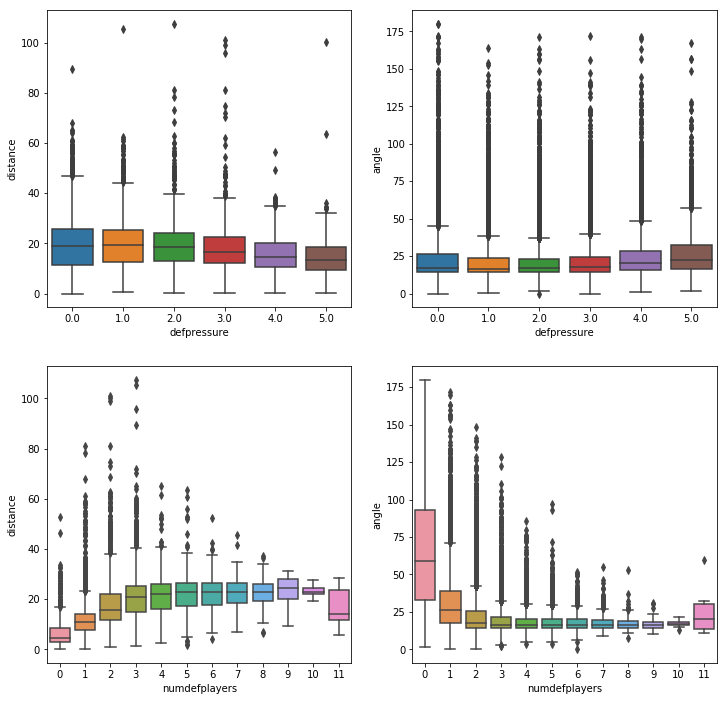

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.boxplot(df.defpressure, df.angle, ax=ax[0,1])
sns.boxplot(df.defpressure, df.distance, ax=ax[0,0])
sns.boxplot(df.numdefplayers, df.angle, ax=ax[1,1])
sns.boxplot(df.numdefplayers, df.distance, ax=ax[1,0]);

In [16]:
color_leagues = {
"AusAL": "xkcd:grey" ,
"AutBL": "xkcd:green" ,
"EngCh": "xkcd:goldenrod" ,
"GerBL2": "xkcd:tomato" ,
"GreSL": "xkcd:purple" ,
"NetED": "xkcd:lilac" ,
"NorEs": "xkcd:aqua" ,
"ScoPr": "xkcd:black" ,
"SweAV": "xkcd:lime" ,
"SwiSL": "xkcd:olive" ,
"TurSL": "xkcd:beige" ,
}

# marker_leagues = {
# "AusAL": "1" ,
# "AutBL": "2" ,
# "EngCh": "3" ,
# "GerBL2": "4" ,
# "GreSL": "8" ,
# "NetED": "o" ,
# "NorEs": "x" ,
# "ScoPr": "+" ,
# "SweAV": "d" ,
# "SwiSL": "s" ,
# "TurSL": "*" ,
# }

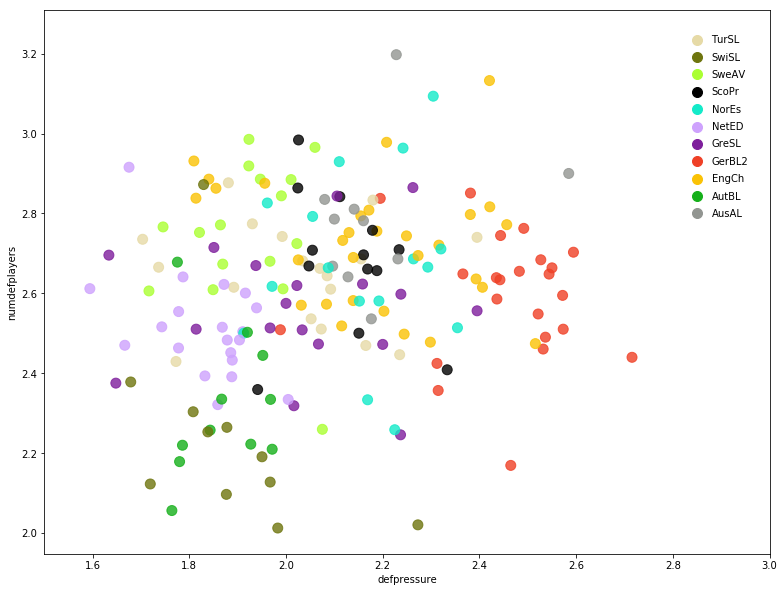

In [17]:
fig, ax = plt.subplots(figsize=(13,10))

df_test = df.groupby(['defending_team', 'competition'], as_index=False).mean()

cs = [color_leagues[x] for x in df_test.competition]

sns.regplot(df_test.defpressure, df_test.numdefplayers, ax=ax, fit_reg=False, 
            scatter_kws={'color':cs, 's':100})

mean_dp = df_test.defpressure.mean()
mean_num = df_test.numdefplayers.mean()

for i, (comp, color) in enumerate(color_leagues.items()):
    ax.scatter(2.85, i/23.0+2.8, color=color, s=100)
    ax.text(2.88, i/23.0+2.8, comp, va='center')

ax.set_xlim(1.5,3);

# for index, row in df_test.iterrows():
#     if mean_dp  - .5 > row['defpressure'] or mean_dp + .5 < row['defpressure'] \
#             or mean_num  - .4 > row['numdefplayers'] or mean_num + .4 < row['numdefplayers']:
#         ax.annotate(row['defending_team'], (row['defpressure'], row['numdefplayers']))

In [18]:
df.groupby('competition').gsm_id.nunique()

competition
AusAL     140
AutBL     280
EngCh     869
GerBL2    468
GreSL     376
NetED     472
NorEs     240
ScoPr     339
SweAV     240
SwiSL     275
TurSL     306
Name: gsm_id, dtype: int64

In [19]:
# add features for defending team
#df['gamestate_defending'] = df['gamestate'] * -1
df['xp_save'] = 3 - df['xp_miss']
df['xp_concede'] = 3 - df['xp_goal']
df['concede_gravity'] = df['xp_save'] - df['xp_concede']

xp-save = xp if not conceding

xp-concede = xp if concededing

Low concede gravity means that it would not really matter if condeding or not, your expected points would be kind of similar.

High concede gravity means that your expected points would be lower if conceding.

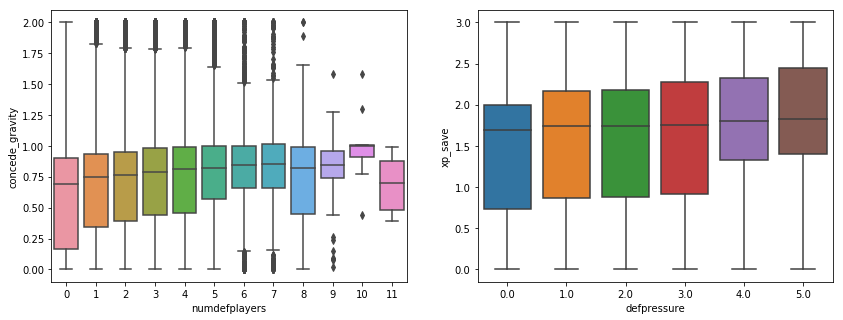

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

sns.boxplot(df.numdefplayers, df.concede_gravity, ax=ax[0])
sns.boxplot(df.defpressure, df.xp_save, ax=ax[1])

119.48333333333333

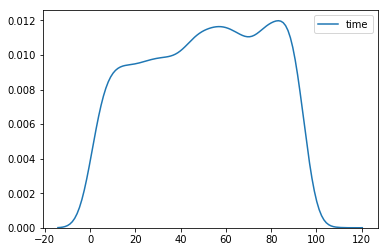

In [21]:
sns.kdeplot(df[df['icon']=='goal']['time']/60)
df.time.max()/60.0

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

preds = ['concede_gravity', 'distance', 'angle', 'gamestate', 'time']
#preds = ['distance', 'angle', 'gamestate']

X = np.matrix(df[preds])

y_ = np.matrix(df[['defpressure', 'numdefplayers']])

x_tr, x_te, y_tr, y_te = train_test_split(X, y_, test_size=0.3, random_state=1066)

In [23]:
from sklearn.model_selection import GridSearchCV
import time


#GS = GridSearchCV(RandomForestRegressor(), {'min_samples_leaf':[10,50,100,200],
 #                         'n_estimators':[50,100,150,200,400,800]})

#GS.fit(X, y_)

#GS.best_params_ # 'min_samples_leaf': 100, 'n_estimators': 800}

In [24]:
# {'min_samples_leaf': 200, 'n_estimators': 800}

#model = RandomForestRegressor(min_samples_leaf=GS.best_params_['min_samples_leaf'],
 #                              n_estimators=GS.best_params_['n_estimators'])

model = RandomForestRegressor(min_samples_leaf=100, n_estimators=200)

model.fit(x_tr, y_tr);

In [25]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
pred_test = model.predict(x_te)

In [27]:
# normalise values to between 0 and 1
print("RMSE defpress:", mean_squared_error(y_te[:,0]/5, pred_test[:,0]/5))
print("RMSE numdef:", mean_squared_error(y_te[:,1]/11, pred_test[:,1]/11))

RMSE defpress: 0.0773452958201
RMSE numdef: 0.0108177982996


In [28]:
# {'min_samples_leaf': 200, 'n_estimators': 800}
# RMSE defpress: 0.07
# RMSE numdef: 0.01

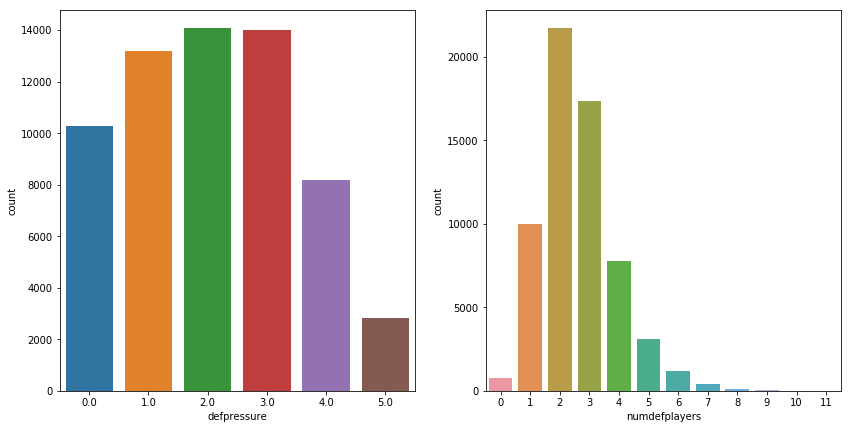

In [29]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

sns.countplot(x='defpressure', data=df, ax=ax[0])
sns.countplot(x='numdefplayers', data=df, ax=ax[1])

In [30]:
for p, c in zip(preds, model.feature_importances_):
    print(p, (c*100).round(3))

concede_gravity 5.296
distance 74.934
angle 11.507
gamestate 3.16
time 5.102


In [31]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
pred_def = model.predict(X)
df['x_def'] = pred_def[:,0]
df['x_num'] = pred_def[:,1]

In [33]:
df_describe = pd.DataFrame()
df_describe['x_def'] = pred_test[:,0]
df_describe['defpress'] = np.squeeze(np.asarray(y_te[:,0]))

df_describe['x_num'] = pred_test[:,1]
df_describe['numdef'] = np.squeeze(np.asarray(y_te[:,1]))

df_describe.describe()

,x_def,defpress,x_num,numdef
count,18755.000000,18755.000000,18755.000000,18755.000000
mean,2.076663,2.093362,2.622671,2.624633
std,0.315017,1.421913,0.602524,1.291795
min,1.063511,0.000000,0.685834,0.000000
25%,1.900994,1.000000,2.158467,2.000000
50%,2.162323,2.000000,2.682315,2.000000
75%,2.304602,3.000000,3.144121,3.000000
max,2.760708,5.000000,3.852413,11.000000


In [34]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df.defpressure/5, df.x_def/5))
print(mean_squared_error(df.numdefplayers/11, df.x_num/11))

0.0753627738548
0.0104645070776


In [35]:
df[['x_def', 'defpressure', 'x_num', 'numdefplayers']].describe()

,x_def,defpressure,x_num,numdefplayers
count,62514.000000,62514.000000,62514.000000,62514.000000
mean,2.075192,2.079918,2.621025,2.621733
std,0.316786,1.419502,0.603892,1.286015
min,1.063511,0.000000,0.685834,0.000000
25%,1.895804,1.000000,2.157852,2.000000
50%,2.161114,2.000000,2.686322,2.000000
75%,2.305315,3.000000,3.143060,3.000000
max,2.760928,5.000000,3.879569,11.000000


In [36]:
# positive = higher press than expected
df['dev_def'] = df['defpressure'] -  df['x_def']
# positive = more defensive players than expected
df['dev_num'] =  df['numdefplayers'] - df['x_num']

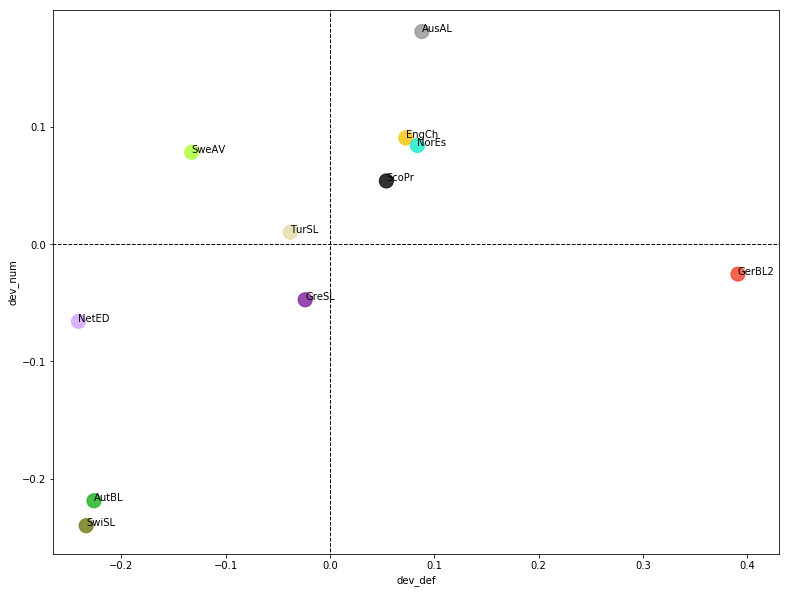

In [37]:
fig, ax = plt.subplots(figsize=(13,10))

df_def = df.groupby(by='competition', as_index=False).mean()

cs = [color_leagues[x] for x in df_def.competition]

sns.regplot('dev_def', 'dev_num', data=df_def, fit_reg=False, ax = ax, 
            scatter_kws={'color':cs,'s':200})

ax.plot((0,0),(-1,1) ,ls='--', lw=1, c='black')
ax.plot((-1,2),(0,0) ,ls='--', lw=1, c='black')

plt.xlim(df_def.dev_def.min()*1.1,df_def.dev_def.max()*1.1)
plt.ylim(df_def.dev_num.min()*1.1,df_def.dev_num.max()*1.1)

mean_dp_dev = df_def.dev_def.mean()
mean_num_dev = df_def.dev_num.mean()

for index, row in df_def.iterrows():
    ax.annotate(row['competition'], (row['dev_def'], row['dev_num']))

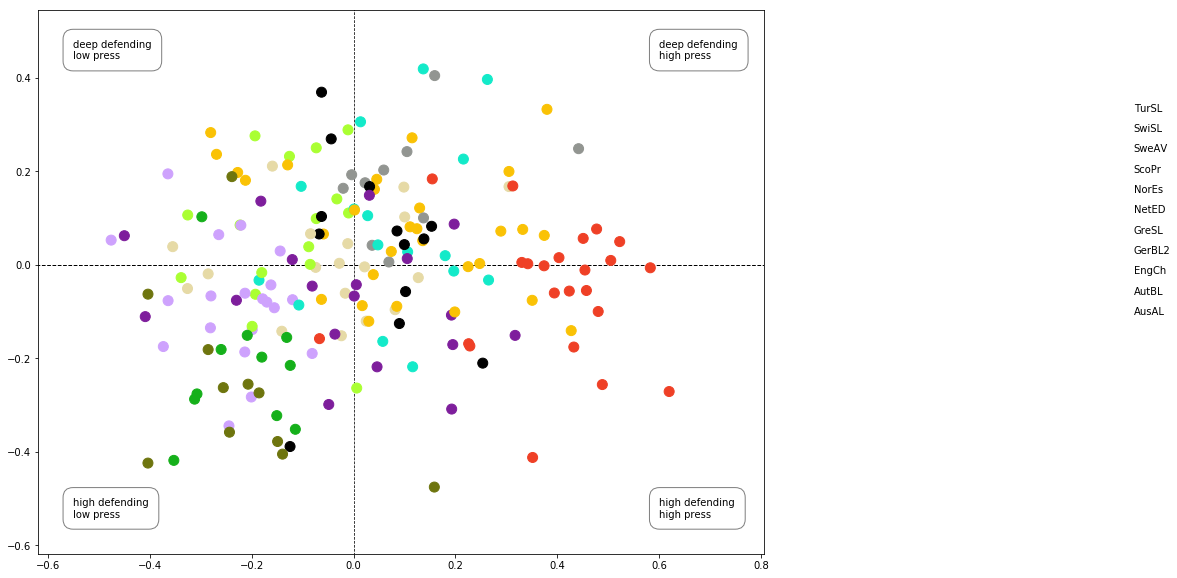

In [38]:
fig, ax = plt.subplots(figsize=(13,10))

df_def = df.groupby(by=['defending_team', 'competition'], as_index=False).mean()
#sns.regplot(df_test.defpressure, df_test.numdefplayers, fit_reg=False, ax=ax)
colors = [color_leagues[x] for x in df_def['competition']]
#markers = [marker_leagues[x] for x in df_def['competition']]

ax.plot((0,0),(-1,1) ,ls='--', c='k', lw=.75, zorder=1)
ax.plot((-1,2),(0,0) ,ls='--', c='k', lw=1)

ax.scatter(df_def.dev_def, df_def.dev_num, c=colors, s=100, zorder=20)

scalar = 1.3
plt.xlim(df_def.dev_def.min()*scalar,df_def.dev_def.max()*scalar)
plt.ylim(df_def.dev_num.min()*scalar,df_def.dev_num.max()*scalar)

mean_dp_dev = df_def.dev_def.mean()
mean_num_dev = df_def.dev_num.mean()

# for index, row in df_def.iterrows():
#     if mean_dp_dev  - .55 > row['dev_num'] or mean_dp_dev + .32 < row['dev_num'] \
#             or mean_num_dev  - .35 > row['dev_def'] or mean_num_dev + .6 < row['dev_def']:
#         ax.annotate(row['defending_team'], (row['dev_def'], row['dev_num']), zorder=21)

# legend        
for i, (comp, color) in enumerate(color_leagues.items()):
    ax.scatter(1.5, i/23.0-.1, color=color, s=70)
    ax.text(1.53, i/23.0-.1, comp, va='center')

x_r, x_l, y_r, y_l = .6, -.55, .44, -.54

ax.text(x_l, y_r, 'deep defending\nlow press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(x_r, y_r, 'deep defending\nhigh press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(x_l, y_l, 'high defending\nlow press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'})

ax.text(x_r, y_l, 'high defending\nhigh press', fontsize=10, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'boxstyle':'round'});

Make a simple xG-model w/o defensive features and see if the team that over/underperform xg are the same that defend deep etc.

In [39]:
df.loc[df['icon'] != "goal", 'goal'] = 0
df.loc[df['icon'] == "goal", 'goal'] = 1

In [40]:
preds = ['angle', 'distance', 'gamestate']

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error, roc_curve, roc_auc_score

# create one matrix for features and one for outcomes
X = np.matrix(df[preds])
y_ = np.array(df['goal'], dtype='int')

# random_state set to some number assures that the random split can be reproduced
x_tr, x_te, y_tr, y_te = train_test_split(X, y_, test_size=0.3, random_state=1066);

In [42]:
lr = LogisticRegression(C=10)
    
lr.fit(x_tr, y_tr)
    
    # test model on test set
pred_test_lr = lr.predict_proba(x_te)#np.array([x[1] for x in lr.predict_proba(x_te)])

In [43]:
pred_all = lr.predict_proba(X)#[x[1] for x in lr.predict_proba(X)]

df['xg'] = pred_all[:,1]

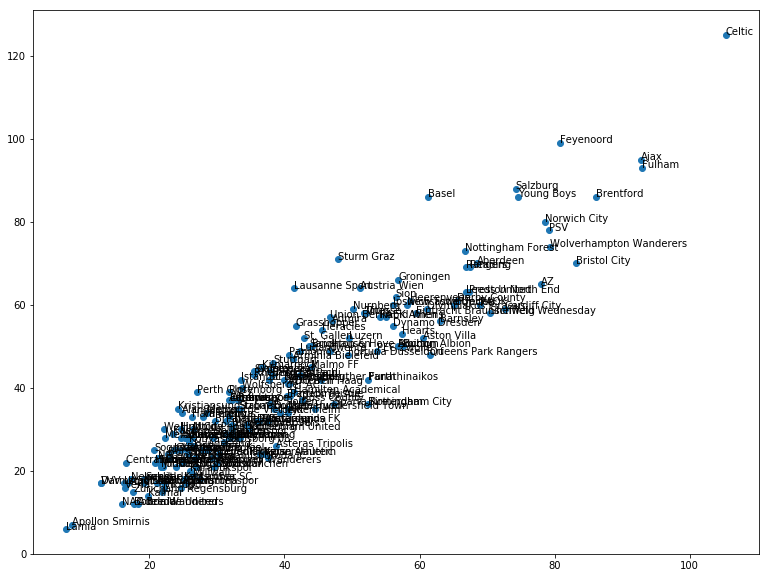

In [44]:
fig, ax = plt.subplots(figsize=(13,10))
df_group = df[['team', 'xg', 'goal']].groupby('team', as_index=False).sum()
ax.scatter(df_group.xg, df_group.goal)

for index, row in df_group.iterrows():
    ax.annotate(row['team'], (row['xg'], row['goal']), zorder=21)

In [45]:
df_group[['xg','goal']].sum()

xg      7357.190853
goal    7391.000000
dtype: float64

Join one df with xg and g to one with defpressure and numdefplayers and expected value of these.

In [46]:
df_def_xg = df[['defending_team', 'xg', 'goal']].groupby('defending_team', as_index=False).sum()
df_def_xg = pd.concat([df_def[['defending_team', 'defpressure', 'numdefplayers', 'dev_def', 'dev_num']], df_def_xg], axis=1)

In [47]:
df_def_xg['xgr'] = df_def_xg['goal'] / df_def_xg['xg']

Text(0,0.5,'les defensive players than expected < dev def > more defensive players than expected')

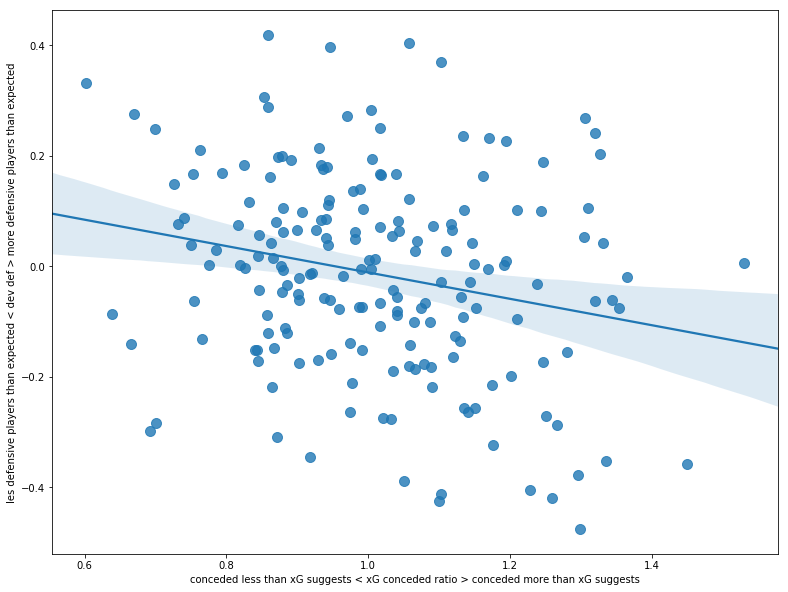

In [48]:
fig, ax = plt.subplots(figsize=(13,10))

#ax.scatter(df_def_xg.xgr, df_def_xg.dev_num, s=100)
sns.regplot(df_def_xg.xgr, df_def_xg.dev_num, scatter_kws={'s':100})

ax.set_xlabel('conceded less than xG suggests < xG conceded ratio > conceded more than xG suggests')
ax.set_ylabel('les defensive players than expected < dev def > more defensive players than expected')

###clustering....

In [49]:
from sklearn.cluster import KMeans
X = df_def[['dev_def', 'dev_num']]

In [50]:
kmeans = KMeans(n_clusters=5).fit(X)
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [51]:
colors_clusters = [x[1] for x in color_leagues.items()]

s = labels.copy()

for i, color in enumerate(colors_clusters[0:len(centroids)]):
    s = [color if x==i else x for x in s]

(-0.52317815071110563, 0.46041341470644737)

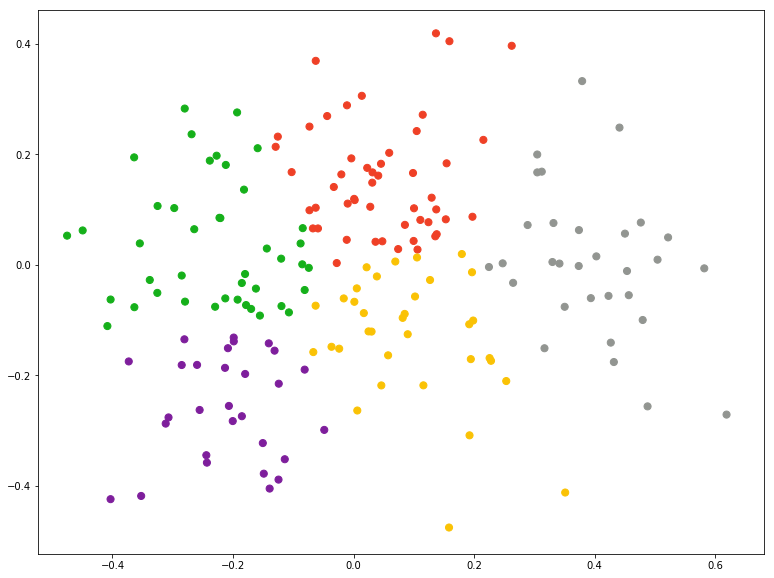

In [52]:
fig, ax = plt.subplots(figsize=(13,10))

df_def = df.groupby(by=['defending_team', 'competition'], as_index=False).mean()
#sns.regplot(df_test.defpressure, df_test.numdefplayers, fit_reg=False, ax=ax)
colors = [color_leagues[x] for x in df_def['competition']]
#markers = [marker_leagues[x] for x in df_def['competition']]


#sns.regplot('dev_def', 'dev_num', data=df_def, fit_reg=False, ax=ax, scatter_kws={'color':cs,'marker':'d'})
ax.scatter(df_def.dev_def, df_def.dev_num, s=50, zorder=20, color=s)

scalar = 1.1
plt.xlim(df_def.dev_def.min()*scalar,df_def.dev_def.max()*scalar)
plt.ylim(df_def.dev_num.min()*scalar,df_def.dev_num.max()*scalar)

In [52]:
#preds = [['defending_team', 'competition', 'gamestate', 'time', 'distance', 'team', 'numattplayers']]
#preds = ['gamestate', 'time', 'distance', 'angle']

#df_pred = pd.concat([df[preds], pd.get_dummies(df['competition'])], join='inner', axis=1)
#df_pred = pd.concat([df_pred, pd.get_dummies(df['defending_team'])], join='inner', axis=1)